# Mid-Ratio Histogram Test

In this section, we take a closer look at the authors' mid ratio test. They look at the ordered triplet (a,b,c); a < b < c and plot the ratio of (b-a)/(c-a) and show an anomaly for the particular RTS. We will conduct the following tests:

To Do - Various plots that we will plot in this section

- First, try to reproduce what the authors did. Figure (1)

- Second, we pool in all the data and try to test for anomalous patterns by singling out each individual from the pool and plotting it compared to the rest of them put together excluding/including the individual?

- Third, we do a permutation test, by making random draws of N_RTS samples from the pooled data (all users) and calibrating the empirical distribution of mid ratio in such a random draw, and then testing for the surprising behavior of the "RTS"'s test statistic.

In [1]:
# import numpy and matlab plot library

import numpy as np

# VERY IMPORTANT line
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt

# import panda
import pandas as pd

# import chisquare statistics
from scipy.stats import chisquare,kstest

In [2]:
# This function takes an N by 3 matrix, sorts the matrix row wise, and then computes the ratio of (mid-min)/(max-min)
# for each row (excludes the rows with all equal entries.)
def compute_ratio(M):
    M.sort(axis=1)
    if (M.shape[1]!=3):
        print 'Size is flawed '
        print M.shape
        
    mid_min = M[:, 1] - M[:, 0]
    max_min = M[:, 2] - M[:, 0]
    ratio = ([mid_min[t]/max_min[t] for t in range(max_min.shape[0]) if max_min[t] !=0 ])
    return np.asarray(ratio)

# This function returns a list of last digits for an np array/ndarray input, and ignores the NAN values
def compute_last_digit(n_arr):
    n_arr = n_arr.flatten()
    return [int (n%10) for n in n_arr if not(np.isnan(n))]

# This function simply plots a histogram of the data (named ratio) with a given title and displays it inline.
def plot_np_hist(ratio, s='Title', show=False):
    plt.hist(ratio, bins=10, normed = False)
    plt.title(s)
    if show:
        plt.show()

# The next two functions are for obtaining histograms that look similar to the ones given in the paper. In these versions
# since we have to include the right hand edge, I do it manually - both the computation and the plotting of the bars.
def compute_my_histogram(ratio):
    v = np.zeros(10)
    N = len(ratio)
    v[0] = np.sum([( x <= 0.1) for x in ratio])
    for i in range(2, 11):
        thr = float(i) /10.
        v[i-1] = np.sum([( x <= thr and x > thr-0.1) for x in ratio])
    v /= np.sum(v)
    return v
def plot_my_histogram(v, s='Title', show=False):
    x = np.linspace(0,1,10,endpoint=False)
    plt.bar(x, v, width=0.1)
    plt.title(s)
    if show:
        plt.show()

In [3]:
# Load the datasets, with the investigator label for the data of the other labmates.

rts_colony_df = pd.read_excel("data/Bishayee Colony Counts 10.27.97-3.8.01.xlsx", 
                              na_values = [' '], skiprows=[0,1], parse_cols = ("D:F"), header = 0)   

rest_colony_df = pd.read_excel("data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx", 
                               na_values = [' '], header = 0, skiprows = [0], parse_cols = ("C:F"))

rts_coulter_df = pd.read_excel("data/Bishayee Coulter Counts.10.20.97-7.16.01.xlsx", 
                               na_values = [' '], skiprows=[1,2], parse_cols = ("C:E"), header = 0)   

rest_coulter_df = pd.read_excel("data/Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.xlsx", 
                                na_values = [' '], header = 0, skiprows = [0], parse_cols = ("C:E,G"))


In [4]:
# Merge the data to create the pool and visualize the shape of the datasets

print rts_colony_df.values[0:3,:]
print rest_colony_df.values[0:3,:] # Tells the first column is investigator label

pool_colony = np.vstack([rts_colony_df.values, rest_colony_df.values[:,-3:]])
print pool_colony.shape

[[ 78.  91.  93.]
 [ 90.  88.  90.]
 [ 80.  66.  69.]]
[[u'I' 266 247.0 262.0]
 [u'I' 170 151.0 156.0]
 [u'I' 66 66.0 56.0]]
(1983, 3)


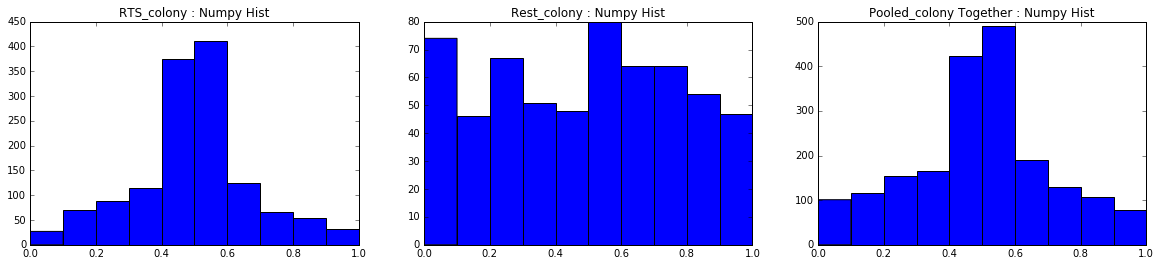

In [5]:
# Compute the ratios
ratio_rts_colony = compute_ratio(rts_colony_df.dropna(axis=0).values[:,-3:])
ratio_rest_colony = compute_ratio(rest_colony_df.dropna(axis=0).values[:,-3:])
ratio_pool_colony = np.concatenate([ratio_rts_colony, ratio_rest_colony])

# Plot simple numpy histograms of mid-ratios for RTS, Rest and Pooled COLONY Data

plt.figure(figsize=[20,4])
plt.subplot(131)
plot_np_hist(ratio_rts_colony, 'RTS_colony : Numpy Hist')
plt.subplot(132)
plot_np_hist(ratio_rest_colony, 'Rest_colony : Numpy Hist')
plt.subplot(133)
plot_np_hist(ratio_pool_colony, 'Pooled_colony Together : Numpy Hist')
plt.show()

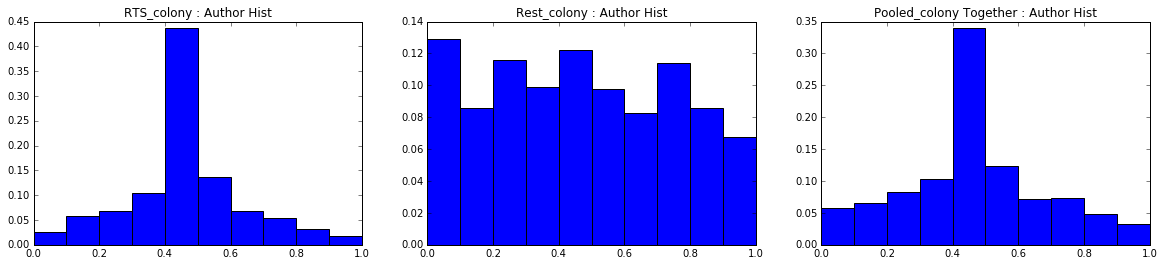

In [6]:
## Here we try to adapt the convetion used by the authors in reporting the histogram. They include the data 
## at the right end of the interval, we correct for it here and see that these new plots look very similar to their plots.

# Compute manually the modified histograms
hist_ratio_colony = compute_my_histogram(ratio_rts_colony)
hist_rest_colony =  compute_my_histogram(ratio_rest_colony)
hist_pool_colony = compute_my_histogram(ratio_pool_colony)

# Plot manually as bars
plt.figure(figsize=[20,4])
plt.subplot(131)
plot_my_histogram(hist_ratio_colony, 'RTS_colony : Author Hist')
plt.subplot(132)
plot_my_histogram(hist_rest_colony, 'Rest_colony : Author Hist')
plt.subplot(133)
plot_my_histogram(hist_pool_colony, 'Pooled_colony Together : Author Hist')
plt.show()

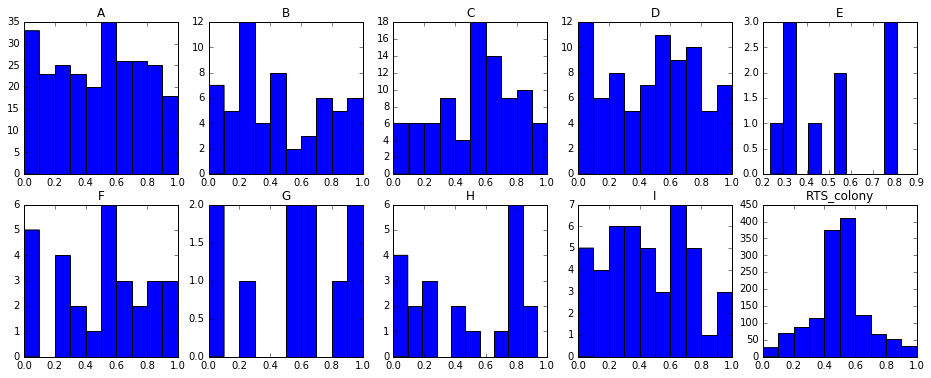

In [8]:
# Now, we decompose the rest group by the unnamed labmates, there are 9 other labmates. We plot the mid-ratio histogram
# using numpy, and also plot the histogram of RTS at the end. Thus there are 10 plots to look at.

def cr_val(df):
    return compute_ratio(df.values[:,-3:])

rr = rest_colony_df.dropna(axis=0).groupby("Inv").apply(cr_val)
plt.figure(figsize = [16,6])
for j in range(rr.shape[0]):
    plt.subplot(2,5,j+1)
    plot_np_hist(rr[j], rr.index[j])
plt.subplot(2,5,10)
plot_np_hist(ratio_rts_colony, 'RTS_colony', True)
plt.show()

In [9]:
print rts_coulter_df.values[0:3,:]
print rest_coulter_df.values[0:3,:] # Indicates the last column is the index of the investigator

pool_coulter = np.vstack([rts_coulter_df.values, rest_coulter_df.values[:,0:3]])

print pool_coulter.shape

[[ 650.  626.  595.]
 [ 460.  455.  468.]
 [ 550.  530.  538.]]
[[1547.0 1574.0 1523.0 u'I']
 [1617.0 1552.0 1570.0 u'I']
 [1258.0 1279.0 1284.0 u'I']]
(2735, 3)


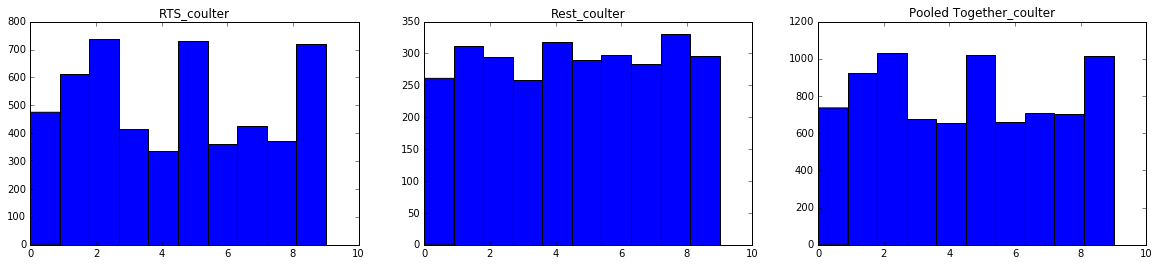

In [11]:
# In this section we plot the distribution of last digit for RTS, Rest and All of them pooled together for the Coulter
# Data. We ignore the NAN values

# Compute the last digit distribution
rld = compute_last_digit(rts_coulter_df.values)
rest_ld = compute_last_digit(rest_coulter_df.values[:,0:3])
pool_ld = np.concatenate([rld, rest_ld])

# Now Plot
plt.figure(figsize=[20,4])
plt.subplot(131)
plot_np_hist(rld, 'RTS_coulter')
plt.subplot(132)
plot_np_hist(rest_ld, 'Rest_coulter')
plt.subplot(133)
plot_np_hist(pool_ld, 'Pooled Together_coulter')
plt.show()

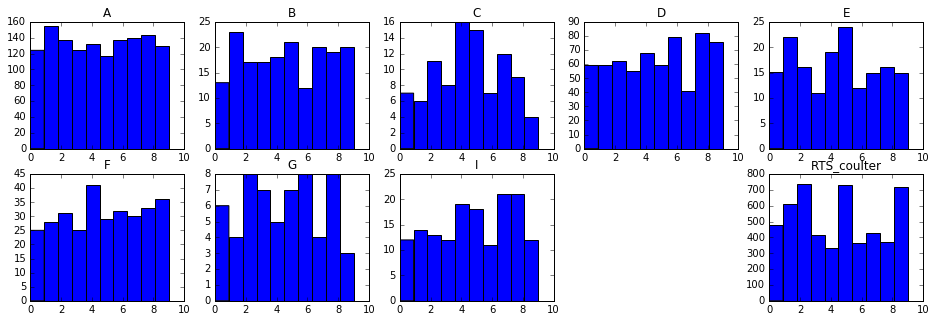

In [13]:
# Now, we decompose the rest group by the unnamed labmates, there are 9 other labmates. We plot last-digit histogram
def cld_val(df):
    return compute_last_digit(df.values[:,0:3])

rest_grouped_ld = rest_coulter_df.groupby("Investigator").apply(cld_val)
plt.figure(figsize = [16,5])
for j in range(rest_grouped_ld.shape[0]):
    plt.subplot(2,5,j+1)
    plot_np_hist(rest_grouped_ld[j], rest_grouped_ld.index[j])
plt.subplot(2,5,10)
plot_np_hist(rld, 'RTS_coulter')
plt.show()

In [136]:
# Permutation Test Set Ups : We use three different test statistics, namely difference in std deviation, l1-distance
# between the two densities, and l1-distance between the two CDFs.

# Compute the difference between std deviation of two datasets
def std_diff(v1, v2):
    return np.abs(np.std(v1)-np.std(v2))

# Computes the l1 distance between empirical densities of two datasets by computing normalized empirical histogram
def density_distance(v1, v2):
    counts1, _ = np.histogram(v1, bins=10, density=True)
    counts1 /= np.sum(counts1)
    counts2, _ = np.histogram(v2, bins=10, density=True)
    counts2 /= np.sum(counts2)
    return np.sum(np.abs(counts1-counts2))

# Computes the l1 distance between empirical CDFs of two datasets by computing normalized empirical histogram
def cdf_distance(v1, v2):
    counts1, _ = np.histogram(v1, bins=10, density=True)
    counts1 /= np.sum(counts1)
    c1 = np.cumsum(counts1)
    counts2, _ = np.histogram(v2, bins=10, density=True)
    counts2 /= np.sum(counts2)
    c2 = np.cumsum(counts2)
    return np.sum(np.abs(c1-c2))

# Performs permutation test by treating xs as the treatment group, and ys as the control group, the local variable zs
# denote the pooled data, and random.shuffle is used to create bootstrapped version of treatment and control groups.
# The function returns the p-value, test-statistic, and all the simulated random values of the test-statistic which 
# are later used to plot histograms for visualization of data by naked eye.
def exact_mc_perm_test(xs, ys, nmc, test_fun=std_diff):
    n, k = len(xs), 0
    diff = test_fun(xs, ys)
    zs = np.concatenate([xs, ys])
    ts = np.zeros(nmc)
    for j in range(nmc):
        np.random.shuffle(zs)
        ts[j] = test_fun(zs[:n],zs[n:])
        k += diff < ts[j]
    return float(k)/nmc , diff, ts

# This function simply reduces the culttering of ticks on x and y axis for clarity.
def pretty_plots(ax, v, name):
    max_yticks = 5
    max_xticks = 5
    plot_np_hist(v, name)
    yloc = plt.MaxNLocator(max_yticks)
    xloc = plt.MaxNLocator(max_xticks)
    ax.yaxis.set_major_locator(yloc)
    ax.xaxis.set_major_locator(xloc)
    
nmc = 1000

Performing Two Sample Permutation Tests using Difference between Std Dev as the Test Statistics
For A, p-value = 0.000000, test-statistic = 0.087149
For B, p-value = 0.000000, test-statistic = 0.087055
For C, p-value = 0.012000, test-statistic = 0.045319
For D, p-value = 0.000000, test-statistic = 0.081577
For E, p-value = 0.894000, test-statistic = 0.006804
For F, p-value = 0.013000, test-statistic = 0.072277
For G, p-value = 0.010000, test-statistic = 0.124325
For H, p-value = 0.003000, test-statistic = 0.107389
For I, p-value = 0.012000, test-statistic = 0.060990
For RTS, p-value = 0.000000, test-statistic = 0.111963


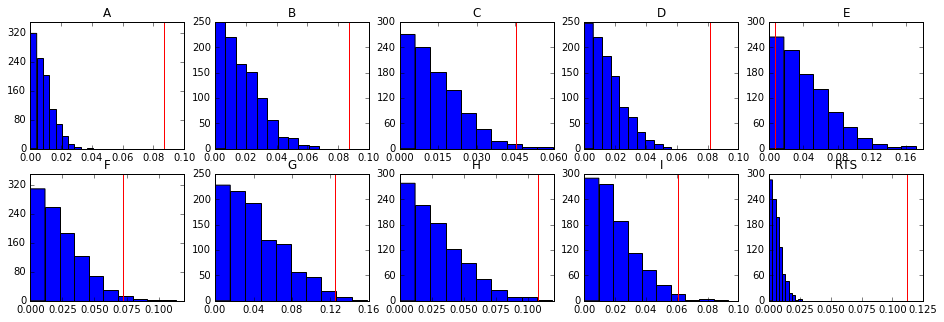

In [137]:
print "Performing Two Sample Permutation Tests using Difference between Std Dev as the Test Statistics"

# Here we simply run the tests on each individual member of the lab by treating him as the "one block" of the partition
# and merging everyone else in the other block of the partition.

# In this section, Difference between Std Dev is the Test Statistics
pval, tstat, statmc = exact_mc_perm_test(ratio_rts_colony, ratio_rest_colony, nmc)
std_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,ratio_rts_colony])
    xs = rn[j]
    std_stat[j] = exact_mc_perm_test(xs, ys, nmc)
    print "For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1])
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, std_stat[j][2], rr.index[j])
    plt.axvline(std_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print "For RTS, p-value = %f, test-statistic = %f" % (pval, tstat)
plt.show()
std_stat['RTS']=pval, tstat, statmc

Performing Two Sample Permutation Tests using l1 distance between DENSITY as the Test Statistics
For A, p-value = 0.000000, test-statistic = 0.087149
For B, p-value = 0.000000, test-statistic = 0.087055
For C, p-value = 0.005000, test-statistic = 0.045319
For D, p-value = 0.000000, test-statistic = 0.081577
For E, p-value = 0.912000, test-statistic = 0.006804
For F, p-value = 0.014000, test-statistic = 0.072277
For G, p-value = 0.019000, test-statistic = 0.124325
For H, p-value = 0.000000, test-statistic = 0.107389
For I, p-value = 0.013000, test-statistic = 0.060990
For RTS, p-value = 0.000000, test-statistic = 0.724160


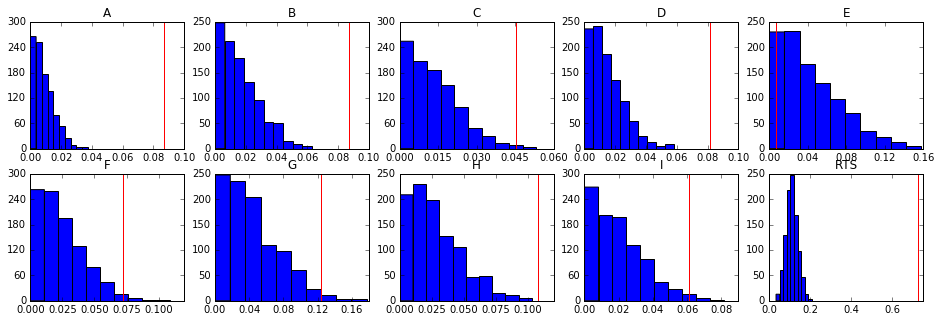

In [138]:
print "Performing Two Sample Permutation Tests using l1 distance between DENSITY as the Test Statistics"

# Here we simply run the tests on each individual member of the lab by treating him as the "one block" of the partition
# and merging everyone else in the other block of the partition.

# In this section, l1 distance between DENSITY is the Test Statistics

pval, tstat, statmc = exact_mc_perm_test(ratio_rts_colony, ratio_rest_colony, nmc, density_distance)
den_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,ratio_rts_colony])
    xs = rn[j]
    den_stat[j] = exact_mc_perm_test(xs, ys, nmc)
    print "For %s, p-value = %f, test-statistic = %f" % (rr.index[j], den_stat[j][0], den_stat[j][1])
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, den_stat[j][2], rr.index[j])
    plt.axvline(den_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print "For RTS, p-value = %f, test-statistic = %f" % (pval, tstat)
plt.show()
den_stat['RTS']=pval, tstat, statmc

Performing Two Sample Permutation Tests using l1 distance between CDF as the Test Statistics
For A, p-value = 0.000000, test-statistic = 0.087149
For B, p-value = 0.000000, test-statistic = 0.087055
For C, p-value = 0.007000, test-statistic = 0.045319
For D, p-value = 0.000000, test-statistic = 0.081577
For E, p-value = 0.894000, test-statistic = 0.006804
For F, p-value = 0.011000, test-statistic = 0.072277
For G, p-value = 0.016000, test-statistic = 0.124325
For H, p-value = 0.001000, test-statistic = 0.107389
For I, p-value = 0.007000, test-statistic = 0.060990
For RTS, p-value = 0.000000, test-statistic = 0.724160


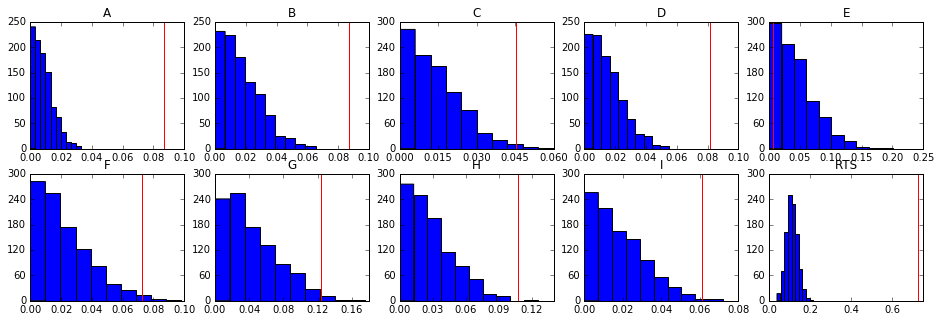

In [139]:
print "Performing Two Sample Permutation Tests using l1 distance between CDF as the Test Statistics"

# Here we simply run the tests on each individual member of the lab by treating him as the "one block" of the partition
# and merging everyone else in the other block of the partition.

# In this section, l1 distance between CDF is the Test Statistics

pval, tstat, statmc = exact_mc_perm_test(ratio_rts_colony, ratio_rest_colony, nmc, density_distance)
cdf_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,ratio_rts_colony])
    xs = rn[j]
    cdf_stat[j] = exact_mc_perm_test(xs, ys, nmc)
    print "For %s, p-value = %f, test-statistic = %f" % (rr.index[j], cdf_stat[j][0], cdf_stat[j][1])
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, cdf_stat[j][2], rr.index[j])
    plt.axvline(cdf_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print "For RTS, p-value = %f, test-statistic = %f" % (pval, tstat)
plt.show()
cdf_stat['RTS']=pval, tstat, statmc

In [ ]:
# # Decomposition of Last DIGIT FOR COLONY DATA

# last_digit_colony = {}
# plt.figure(figsize = [16,5])
# for group in range(rest_colony_grouped.shape[0]):
#     last_digit_colony[group] = compute_last_digit(rest_colony_grouped[group])
#     plt.subplot(2,5, group+1)
#     plot_np_hist(last_digit_colony[group], names_colony[group])
# plt.subplot(2,5,10)
# plot_np_hist(compute_last_digit(rts_colony), 'RTS_colony', True)
# plt.show()


# for j in range(num_test):
#     idx_rts = np.random.choice(idxs, num_rts, replace=False)
#     idx_rest = np.setdiff1d(idxs, idx_rts)
#     rts_samp_ratio = pool_ratio[idx_rts]
#     rest_samp_ratio = pool_ratio[idx_rest]
#     stat[j] = np.mean(rts_ratio)-np.mean(rest_ratio)

# idx_rest = np.setdiff1d(idxs, idx_rts)

# np.setdiff1d(np.union1d(idx_rts, idx_rest), idxs)

# def exact_mc_perm_test_xz(xs, zs, tstat, nmc):
#     n, k = len(xs), 0
#     ts = np.zeros(nmc)
#     for j in range(nmc):
#         np.random.shuffle(zs)
#         ts[j] = np.abs(np.std(zs[:n]) - np.std(zs[n:]))
#         k += tstat < ts[j]
#     return float(k)/nmc , diff, ts   

